In [1]:
INPUT = "model_data/example_study"

In [2]:
# Standard library imports
import os
import math
import glob
import json
import pickle

# Third-party library imports
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import pydicom
import sklearn
import sklearn.metrics

# Hugging Face Hub
from huggingface_hub import PyTorchModelHubMixin

# Local module imports
import utils
import video_utils

In [3]:
#device=torch.device("cuda")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

Device: mps


In [4]:
vc_checkpoint = torch.load("model_data/weights/view_classifier.ckpt", map_location=device, weights_only=False)
vc_state_dict={key[6:]:value for key,value in vc_checkpoint['state_dict'].items()}

view_classifier = torchvision.models.convnext_base()
view_classifier.classifier[-1] = torch.nn.Linear(
    view_classifier.classifier[-1].in_features, 11
)
view_classifier.load_state_dict(vc_state_dict)
view_classifier.to(device)
view_classifier.eval()
for param in view_classifier.parameters():
    param.requires_grad = False

In [5]:
frames_to_take=32
frame_stride=2
video_size=224
mean = torch.tensor([29.110628, 28.076836, 29.096405]).reshape(3, 1, 1, 1)
std = torch.tensor([47.989223, 46.456997, 47.20083]).reshape(3, 1, 1, 1)

def process_dicoms(INPUT):
    """
    Reads DICOM video data from the specified folder and returns a tensor 
    formatted for input into the EchoPrime model.

    Args:
        INPUT (str): Path to the folder containing DICOM files.

    Returns:
        stack_of_videos (torch.Tensor): A float tensor of shape  (N, 3, 16, 224, 224)
                                        representing the video data where N is the number of videos,
                                        ready to be fed into EchoPrime.
    """

    dicom_paths = glob.glob(f'{INPUT}/**/*.dcm',recursive=True)
    stack_of_videos=[]
    for idx, dicom_path in tqdm(enumerate(dicom_paths),total=len(dicom_paths)):
        try:
            # simple dicom_processing
            dcm=pydicom.dcmread(dicom_path)
            #pixels = dcm.pixel_array
            pixels = pydicom.pixels.convert_color_space(dcm.pixel_array, 'RGB', 'YBR_FULL', per_frame=True)
            
            # exclude images like (600,800) or (600,800,3)
            if pixels.ndim < 3 or pixels.shape[2]==3:
                continue 
                
            # if single channel repeat to 3 channels    
            if pixels.ndim==3:
                
                pixels = np.repeat(pixels[..., None], 3, axis=3)
            
            # mask everything outside ultrasound region
            pixels=video_utils.mask_outside_ultrasound(dcm.pixel_array)
            
            #model specific preprocessing
            x = np.zeros((len(pixels),224,224,3))
            for i in range(len(x)):
                x[i] = video_utils.crop_and_scale(pixels[i])
            
            x = torch.as_tensor(x, dtype=torch.float).permute([3,0,1,2])
            # normalize
            x.sub_(mean).div_(std)
        
            ## if not enough frames add padding
            if x.shape[1] < frames_to_take:
                padding = torch.zeros(
                (
                    3,
                    frames_to_take - x.shape[1],
                    video_size,
                    video_size,
                ),
                dtype=torch.float,
                )
                x = torch.cat((x, padding), dim=1)
                
            start=0
            stack_of_videos.append(x[:, start : ( start + frames_to_take) : frame_stride, : , : ])
            
        except Exception as e:
            print("corrupt file")
            print(str(e))

    stack_of_videos=torch.stack(stack_of_videos)
    
    return stack_of_videos

In [116]:
def get_view_list(stack_of_videos, visualize=False):
    """
    Args:
        stack_of_videos (torch.Tensor): A float tensor with preprocessed echo video data
        
    Returns:
        view_list A list of predicted views
    """
    ## get views   
    stack_of_first_frames = stack_of_videos[:,:,0,:,:].to(device)
    #stack_of_first_frames = stack_of_videos[:,0,:,:].to(device)

    with torch.no_grad():
        out_logits=view_classifier(stack_of_first_frames)
    out_views=torch.argmax(out_logits,dim=1)
    view_list = [utils.COARSE_VIEWS[v] for v in out_views]

    #print(out_logits)
    print(out_views)
    print(view_list)

    # visualize images and the assigned views
    if visualize:
        print("Preprocessed and normalized video inputs")
        #rows, cols = (len(view_list) // 12 + (len(view_list) % 9 > 0)), 12
        rows, cols = (len(view_list) // 4 + (len(view_list) % 9 > 0)), 4

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 8))
        
        axes = axes.flatten()
        for i in range(len(view_list)):
            display_image = (stack_of_first_frames[i].cpu().permute([1,2,0]) * 255).numpy()
            display_image = np.clip(display_image, 0, 255).astype('uint8')
            display_image = np.ascontiguousarray(display_image)
            display_image = cv2.cvtColor(display_image, cv2.COLOR_RGB2BGR)
            cv2.putText(display_image, view_list[i].replace("_"," "), (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 220, 255), 2)
            axes[i].imshow(display_image)
            axes[i].axis('off')

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.show()

        
    return view_list

In [7]:
stack_of_videos=process_dicoms(INPUT)

100%|██████████| 50/50 [01:16<00:00,  1.52s/it]


In [73]:
stack_of_videos[4:14,:,:,:,:].shape

torch.Size([10, 3, 16, 224, 224])

tensor([ 2,  7,  2, 10,  6,  0,  8,  7,  4,  1,  6,  6])
['A4C', 'Parasternal_Long', 'A4C', 'Subcostal', 'Doppler_Parasternal_Short', 'A2C', 'Parasternal_Short', 'Parasternal_Long', 'Apical_Doppler', 'A3C', 'Doppler_Parasternal_Short', 'Doppler_Parasternal_Short']
Preprocessed and normalized video inputs


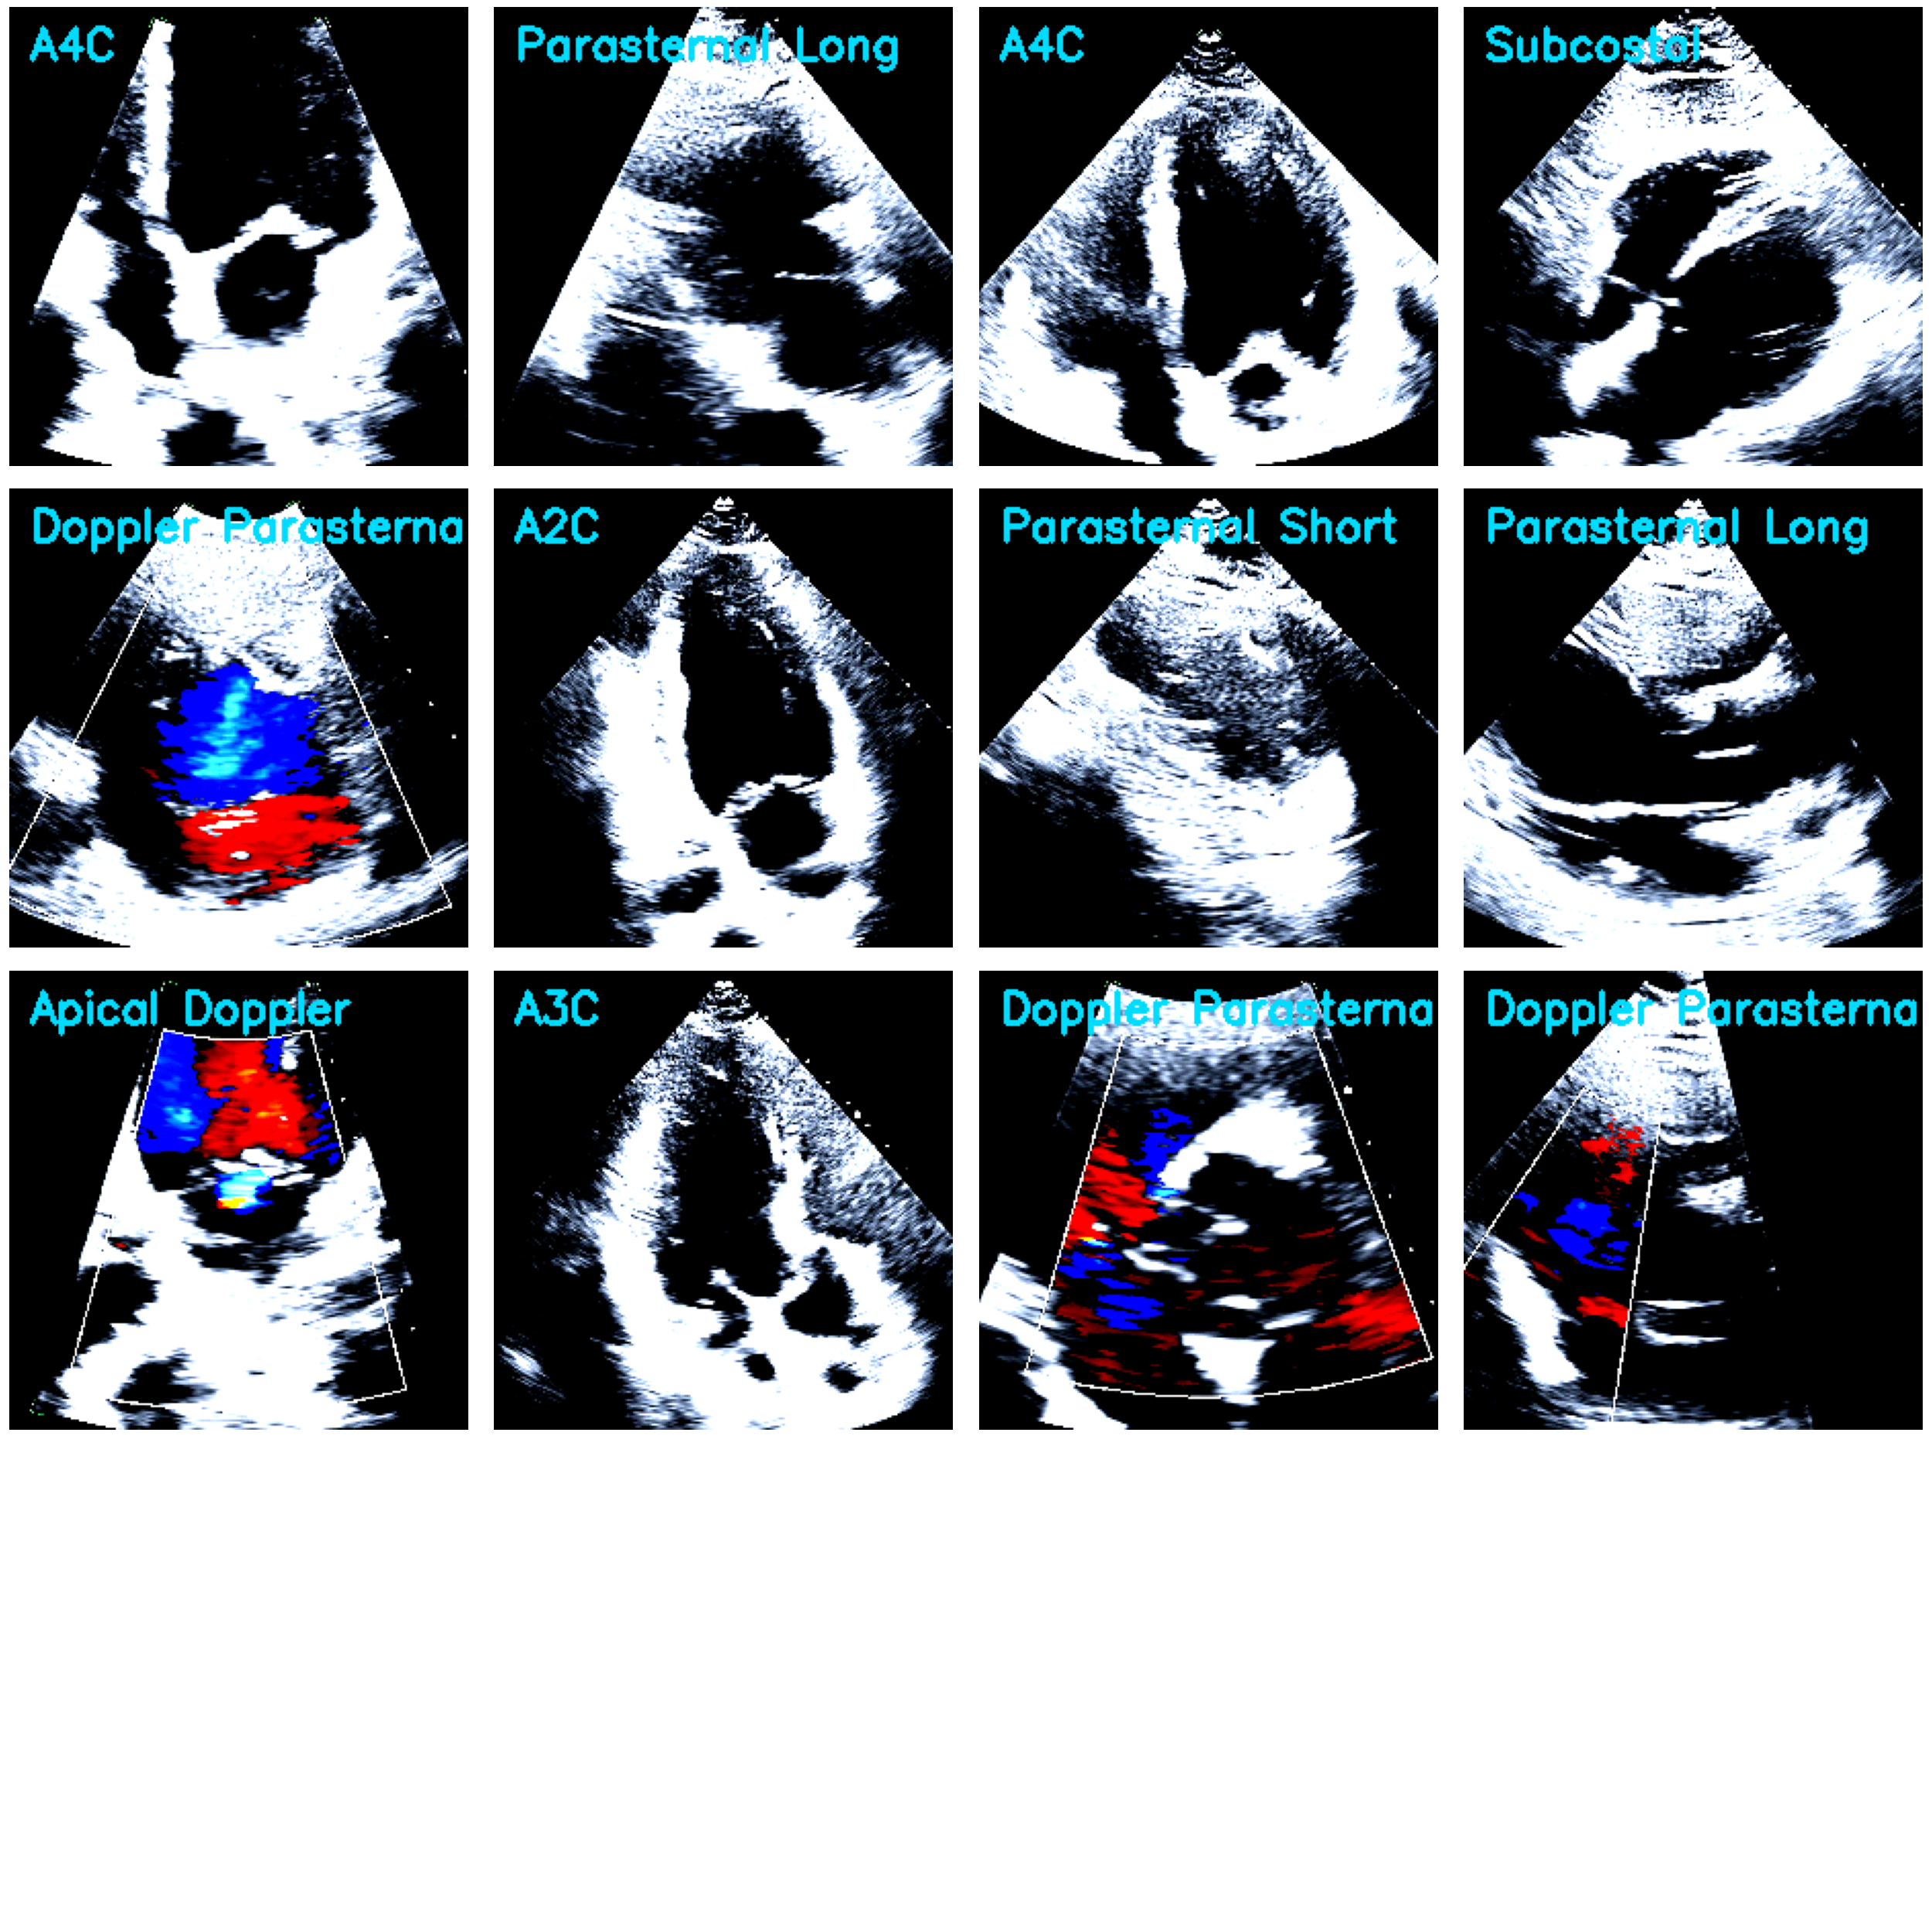

['A4C', 'Parasternal_Long', 'A4C', 'Subcostal', 'Doppler_Parasternal_Short', 'A2C', 'Parasternal_Short', 'Parasternal_Long', 'Apical_Doppler', 'A3C', 'Doppler_Parasternal_Short', 'Doppler_Parasternal_Short']


In [117]:
view_list=get_view_list(stack_of_videos[4:16,:,:,:,:],visualize=True)
print(view_list)

# Grad-CAM Implementation

In [25]:

# Load ConvNeXt Classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vc_checkpoint = torch.load("model_data/weights/view_classifier.ckpt", map_location=device)
vc_state_dict = {key[6:]: value for key, value in vc_checkpoint['state_dict'].items()}

view_classifier = torchvision.models.convnext_base()
view_classifier.classifier[-1] = torch.nn.Linear(
    view_classifier.classifier[-1].in_features, 11
)
view_classifier.load_state_dict(vc_state_dict)
view_classifier.to(device)
view_classifier.eval()

# Freeze all parameters *except* the last conv layer
for param in view_classifier.parameters():
    param.requires_grad = False  # Keep frozen

# Unfreeze the last convolutional layer for Grad-CAM
for param in view_classifier.features.parameters():  # Features contain conv layers
    param.requires_grad = True  # Enable gradients here


# Identify the last convolutional layer (ConvNeXt uses 'features' before classifier)
target_layer = view_classifier.features  # Last convolutional block

# Hook containers
act_map = {}
grad_map = {}

# Forward hook to capture activations
def forward_hook(module, inp, out):
    act_map["value"] = out.detach()

# Backward hook to capture gradients
def backward_hook(module, grad_in, grad_out):
    grad_map["value"] = grad_out[0].detach()

# Register hooks
forward_handle = target_layer.register_forward_hook(forward_hook)
backward_handle = target_layer.register_backward_hook(backward_hook)


/var/folders/25/w8v43z6j639cqlmdf65fbl9h0000gn/T/ipykernel_41646/199305459.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vc_checkpoint = torch.load("model_data/weights

In [200]:
# Function to compute Grad-CAM
def compute_gradcam(model, input_tensor):
    """
    Generates Grad-CAM heatmap for a single input frame.
    Args:
        model: The ConvNeXt model.
        input_tensor: Preprocessed input frame of shape [1, 3, H, W].
    Returns:
        cam_map_np: The Grad-CAM heatmap as a numpy array.
    """
    model.zero_grad()
    
    input_tensor.requires_grad_()

    output = model(input_tensor)  # Forward pass

    output.requires_grad_()

    pred_class = output.argmax(dim=1).item()  # Get predicted class
    class_score = output[0, pred_class]  # Score for predicted class

    view_list = [utils.COARSE_VIEWS[v] for v in output.argmax(dim=1)]

    class_gt = view_list[0].replace("_"," ")

    print(output)
    print(pred_class)
    print(class_score)
    print(f"Class Score (before backward): {class_score}, requires_grad={class_score.requires_grad}")
    print(f"View: {view_list}")
    print(f"Ground Truth: {class_gt}")

    if not class_score.requires_grad:
        class_score.retain_grad()

    # Backward pass
    class_score.backward()

    # Get activations and gradients
    activations = act_map["value"]  # Shape: [1, C, H', W']
    gradients = grad_map["value"]  # Shape: [1, C, H', W']

    # Global average pooling of gradients
    weights = torch.mean(gradients, dim=(2, 3))[0]  # Shape: [C]

    # Compute weighted sum of activations
    weighted_sum = torch.zeros_like(activations[0])  # Shape: [C, H', W']
    for i, w in enumerate(weights):
        weighted_sum[i] = activations[0, i] * w
    cam_map = weighted_sum.sum(dim=0)  # Shape: [H', W']

    # Apply ReLU and normalize
    cam_map = torch.relu(cam_map)
    cam_map = cam_map / cam_map.max()
    return cam_map.cpu().numpy(), class_gt # Convert to numpy


In [124]:
# Function to overlay Grad-CAM heatmap on input tensor itself
def overlay_gradcam_on_input(input_tensor, cam_map_np, class_gt, alpha=0.4):
    """
    Overlays Grad-CAM heatmap directly onto the input tensor.
    Args:
        input_tensor: Preprocessed input tensor of shape [1, 3, H, W] (already normalized).
        cam_map_np: Grad-CAM heatmap array (H', W') to be resized.
        alpha: Transparency of the overlay.
    Returns:
        overlayed_rgb: The final image with Grad-CAM overlaid.
    """
    input_np = input_tensor.detach().squeeze(0).permute(1, 2, 0).cpu().numpy()  # Shape: [H, W, 3]
    
    # Normalize input tensor to [0, 255] for visualization
    input_np = (input_np - input_np.min()) / (input_np.max() - input_np.min())  # Normalize to [0,1]
    input_np = np.uint8(255 * input_np)  # Convert to [0, 255]

    # Resize heatmap to match input size
    H, W, _ = input_np.shape
    heatmap_resized = cv2.resize(cam_map_np, (W, H))
    heatmap_resized = np.uint8(255 * heatmap_resized)  # Scale to 0-255


    # Apply JET colormap
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Blend heatmap with input image
    overlayed_bgr = cv2.addWeighted(input_np, 1 - alpha, heatmap_color, alpha, 0)

    text_position = (10, 25)  # Same position as before
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (60, 200, 100)  # Same cyan-yellow color
    thickness = 1

    # Overlay text
    #cv2.putText(overlayed_bgr, class_gt, text_position, font, font_scale, font_color, thickness)


    input_bgr = cv2.cvtColor(input_np, cv2.COLOR_RGB2BGR)  # Convert input to BGR for text
    #cv2.putText(input_bgr, class_gt, text_position, font, font_scale, font_color, thickness)
    cv2.putText(overlayed_bgr, class_gt, text_position, font, font_scale, font_color, thickness)

    # Stack images side by side
    white_space = np.ones((H, 8, 3), dtype=np.uint8) * 255  # White RGB (255,255,255)
    side_by_side_img = np.hstack([input_bgr, white_space, overlayed_bgr])  # Add separator

    # Convert back to RGB for Matplotlib display
    #return cv2.cvtColor(side_by_side_img, cv2.COLOR_BGR2RGB)

    # Convert back to RGB for display
    return cv2.cvtColor(overlayed_bgr, cv2.COLOR_BGR2RGB)

In [125]:
# Example usage
def process_single_frame(model, frame_tensor):
    """
    Processes a single echo frame, computes Grad-CAM, and overlays the heatmap on input itself.
    Args:
        model: Trained ConvNeXt model.
        frame_tensor: Preprocessed input frame tensor.
    """
    input_tensor = frame_tensor.unsqueeze(0).to(device)  # Add batch dimension
    cam_map_np, class_gt = compute_gradcam(model, input_tensor)  # Generate Grad-CAM
    overlayed_image = overlay_gradcam_on_input(input_tensor, cam_map_np, class_gt)  # Overlay on input

    # Display the result
    plt.imshow(overlayed_image)
    #plt.title("Grad-CAM on Input Tensor")
    plt.axis("off")
    plt.show()

/Users/pb7/.pyenv/versions/3.11.10/envs/py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


tensor([[ 1.8072,  0.7635,  9.8882,  4.6729,  2.4985, -6.9919, -5.4104, -0.1755,
          0.3180, -3.1104, -2.1774]], grad_fn=<AddmmBackward0>)
2
tensor(9.8882, grad_fn=<SelectBackward0>)
Class Score (before backward): 9.888203620910645, requires_grad=True
View: ['A4C']
Ground Truth: A4C


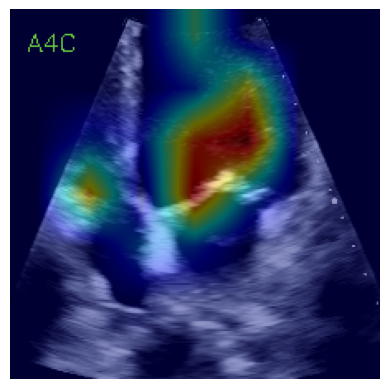

In [201]:
frame_tensor = stack_of_videos[4,:,0,:,:] # 0, 2, 4, 6, 8
frame_tensor.shape
process_single_frame(view_classifier, frame_tensor)

In [47]:

# Cleanup: Remove hooks after computing Grad-CAM
forward_handle.remove()
backward_handle.remove()

# Occlusion sensitivity analysis

In [197]:
frame_tensor = stack_of_videos[8,:,0,:,:] # 0, 2, 4, 6, 8


def occlusion_sensitivity_analysis(model, input_tensor, patch_size=20, stride=10):
    """
    Perform occlusion sensitivity analysis by systematically masking regions of the input image 
    and observing the impact on classification confidence.

    Args:
        model: The trained classification model.
        input_tensor: The input image tensor of shape [1, 3, H, W].
        patch_size: The size of the square patch to occlude.
        stride: The step size for moving the occlusion window.

    Returns:
        occlusion_map: A heatmap showing the importance of different regions.
    """
    model.eval()
    input_tensor = input_tensor.clone().detach().to(device)

    _, _, H, W = input_tensor.shape
    occlusion_map = np.zeros((H, W))

    base_prediction = model(input_tensor)
    base_confidence = torch.max(torch.nn.functional.softmax(base_prediction, dim=1)).item()

    for y in range(0, H - patch_size, stride):
        for x in range(0, W - patch_size, stride):
            occluded_tensor = input_tensor.clone()
            occluded_tensor[:, :, y:y+patch_size, x:x+patch_size] = torch.mean(input_tensor)

            with torch.no_grad():
                output = model(occluded_tensor)
                confidence = torch.max(torch.nn.functional.softmax(output, dim=1)).item()

            occlusion_map[y:y+patch_size, x:x+patch_size] = base_confidence - confidence

    # Normalize occlusion map
    occlusion_map = (occlusion_map - occlusion_map.min()) / (occlusion_map.max() - occlusion_map.min())
    
    return occlusion_map


In [198]:

# Example usage:
input_tensor = frame_tensor.unsqueeze(0).to(device)
occlusion_map = occlusion_sensitivity_analysis(view_classifier, input_tensor)


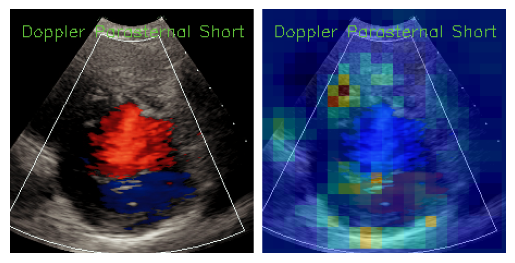

In [199]:
class_gt = "Doppler Parasternal Short"

# Convert occlusion map to heatmap
occlusion_map = np.uint8(255 * occlusion_map)
occlusion_map = cv2.applyColorMap(occlusion_map, cv2.COLORMAP_JET)

# Convert input tensor to image
input_np = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
input_np = (input_np - input_np.min()) / (input_np.max() - input_np.min())  # Normalize
input_np = np.uint8(255 * input_np)

# Overlay occlusion map on input image
overlayed_occlusion = cv2.addWeighted(input_np, 0.6, occlusion_map, 0.4, 0)


text_position = (10, 25)  # Same position as before
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_color = (60, 200, 100)  # Same cyan-yellow color
thickness = 1

input_bgr = cv2.cvtColor(input_np, cv2.COLOR_RGB2BGR)  # Convert input to BGR for text

cv2.putText(input_bgr, class_gt, text_position, font, font_scale, font_color, thickness)
cv2.putText(overlayed_occlusion, class_gt, text_position, font, font_scale, font_color, thickness)


# Show the result
space_width = 8  # Adjust this value for more or less separation
white_space = np.ones((input_np.shape[0], space_width, 3), dtype=np.uint8) * 255  # White separator
side_by_side = np.hstack([input_bgr, white_space, overlayed_occlusion])

# Display the result
plt.imshow(cv2.cvtColor(side_by_side, cv2.COLOR_BGR2RGB))
#plt.title("Original vs Occlusion Sensitivity Analysis")
plt.axis("off")
plt.show()